In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
from cryptocompy import coin,price
import tqdm
import seaborn as sns
sns.set();

import io
import requests
import json
from datetime import datetime
import time
from time import gmtime, strftime

from sklearn import metrics
from fbprophet import Prophet
plt.rcParams["figure.figsize"] = [14,8]
pd.set_option('float_format', '{:f}'.format)

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import datetime
from datetime import datetime as dt
from datetime import timedelta


from tqdm import tqdm_notebook
from livelossplot.keras import PlotLossesCallback


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool, cv
import catboost
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
#from sklearn.cross_validation import cross_val_score
#from sklearn.grid_search import GridSearchCV
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM
from keras.layers.advanced_activations import LeakyReLU

from keras import optimizers
from keras import backend as K

adam = optimizers.Adam(lr=0.01, clipnorm=1.)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
def nn_r2_score(y_true, y_pred):
    total_error = K.sum(K.square( y_true - K.mean(y_true) ) )
    residual_error = K.sum(K.square( y_true - y_pred ))
    R_squared = 1 - (residual_error / total_error)
    return -R_squared

Using TensorFlow backend.


In [2]:
def supres(low, high, n=28, min_touches=2, stat_likeness_percent=1.5, bounce_percent=5):
    """Support and Resistance Testing
    Identifies support and resistance levels of provided price action data.
    Args:
        n(int): Number of frames to evaluate
        low(pandas.Series): A pandas Series of lows from price action data.
        high(pandas.Series): A pandas Series of highs from price action data.
        min_touches(int): Minimum # of touches for established S&R.
        stat_likeness_percent(int/float): Acceptable margin of error for level.
        bounce_percent(int/float): Percent of price action for established bounce.
    
    ** Note **
        If you want to calculate support and resistance without regard for
        candle shadows, pass close values for both low and high.
    Returns:
        sup(float): Established level of support or None (if no level)
        res(float): Established level of resistance or None (if no level)
    """
    import pandas as pd
    import numpy as np

    # Collapse into dataframe
    df = pd.concat([high, low], keys = ['high', 'low'], axis=1)
    df['sup'] = pd.Series(np.zeros(len(low)))
    df['res'] = pd.Series(np.zeros(len(low)))
    df['sup_break'] = pd.Series(np.zeros(len(low)))
    df['sup_break'] = 0
    df['res_break'] = pd.Series(np.zeros(len(high)))
    df['res_break'] = 0
    
    for x in range((n-1)+n, len(df)):
        # Split into defined timeframes for analysis
        tempdf = df[x-n:x+1]
        
        # Setting default values for support and resistance to None
        sup = None
        res = None
        
        # Identifying local high and local low
        maxima = tempdf.high.max()
        minima = tempdf.low.min()
        
        # Calculating distance between max and min (total price movement)
        move_range = maxima - minima
        
        # Calculating bounce distance and allowable margin of error for likeness
        move_allowance = move_range * (stat_likeness_percent / 100)
        bounce_distance = move_range * (bounce_percent / 100)
        
        # Test resistance by iterating through data to check for touches delimited by bounces
        touchdown = 0
        awaiting_bounce = False
        for y in range(0, len(tempdf)):
            if abs(maxima - tempdf.high.iloc[y]) < move_allowance and not awaiting_bounce:
                touchdown = touchdown + 1
                awaiting_bounce = True
            elif abs(maxima - tempdf.high.iloc[y]) > bounce_distance:
                awaiting_bounce = False
        if touchdown >= min_touches:
            res = maxima
        # Test support by iterating through data to check for touches delimited by bounces
        touchdown = 0
        awaiting_bounce = False
        for y in range(0, len(tempdf)):
            if abs(tempdf.low.iloc[y] - minima) < move_allowance and not awaiting_bounce:
                touchdown = touchdown + 1
                awaiting_bounce = True
            elif abs(tempdf.low.iloc[y] - minima) > bounce_distance:
                awaiting_bounce = False
        if touchdown >= min_touches:
            sup = minima
        if sup:
            df['sup'].iloc[x] = sup
        if res:
            df['res'].iloc[x] = res
    res_break_indices = list(df[(np.isnan(df['res']) & ~np.isnan(df.shift(1)['res'])) & (df['high'] > df.shift(1)['res'])].index)
    for index in res_break_indices:
        df['res_break'].at[index] = 1
    sup_break_indices = list(df[(np.isnan(df['sup']) & ~np.isnan(df.shift(1)['sup'])) & (df['low'] < df.shift(1)['sup'])].index)
    for index in sup_break_indices:
        df['sup_break'].at[index] = 1
    ret_df = pd.concat([df['sup'], df['res'], df['sup_break'], df['res_break']], keys = ['sup', 'res', 'sup_break', 'res_break'], axis=1)
    return ret_df

In [3]:
coin = 'XRP'
df = price.get_historical_data(coin, 'BTC', 'day', aggregate=1, limit=2000)
df = pd.DataFrame(df)
df = df[df['close']!=0]
df['Date'] = df['time'].apply(lambda x: x[:10])
df['Date'] = pd.to_datetime(df['Date'])
df = df[['close','Date']]
df.columns = ['y','ds']
#temp = supres(df['low'],df['high'])
#temp['close'] = df['close']
#temp.fillna(0, inplace=True)

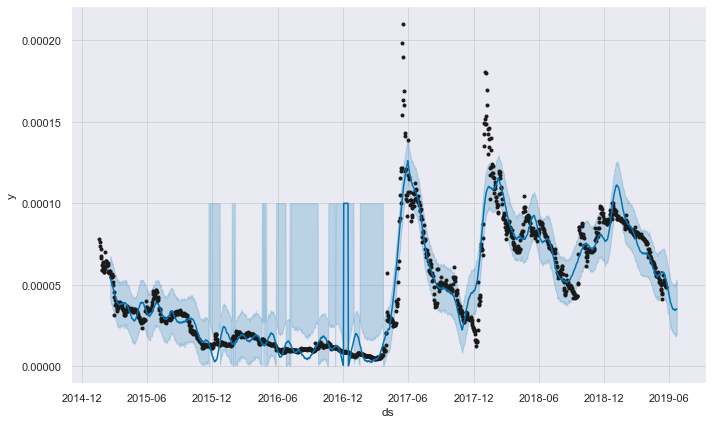

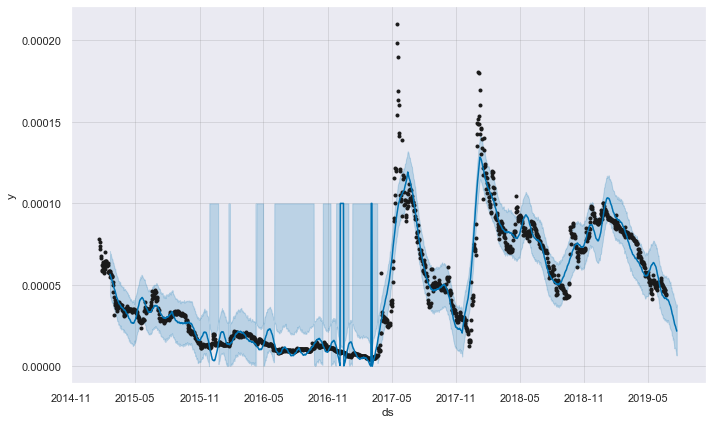

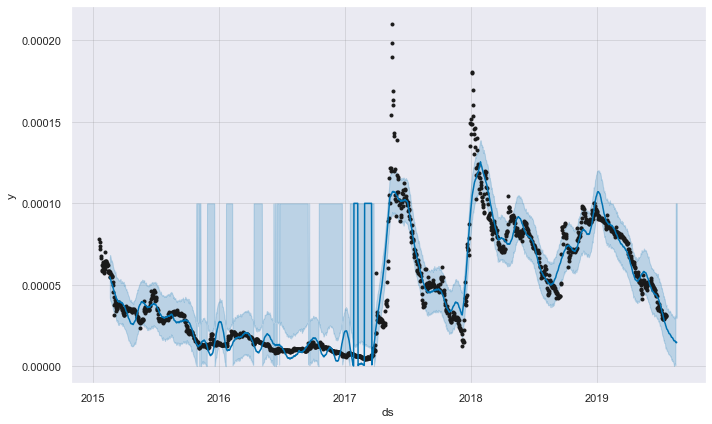

In [4]:
days = 30
t = [90,60,30]
pred = pd.DataFrame()
for te in t:
    data = df[['y','ds']][:-te]
    if te == 30:
        true = df['y'][-30:]
    else:
        true = df['y'][-te:-(te-days)]
    
    model = Prophet(changepoint_prior_scale=0.7,n_changepoints=25, daily_seasonality=True,changepoint_range=0.8).fit(data)

    data_forecast = data['ds'] + pd.Timedelta(30, unit='days')
    data_forecast = pd.DataFrame(data_forecast)
    data_forecast.columns = ['ds']
    forecast = model.predict(data_forecast)
    forecast['yhat'] = np.where(forecast['yhat']<0,0.0001,forecast['yhat'])
    forecast['yhat_lower'] = np.where(forecast['yhat_lower']<0,0.0001,forecast['yhat_lower'])
    forecast['yhat_upper'] = np.where(forecast['yhat_upper']<0,0.0001,forecast['yhat_upper'])
    model.plot(forecast);
    y = pd.DataFrame()
    y['True'] = true
    y['Forecasted'] = forecast['yhat'].iloc[-30:].values
    score = []
    for i in range(len(y)):
        if y['True'].iloc[i] > y['Forecasted'].iloc[i]:
            score.append(y['Forecasted'].iloc[i] / y['True'].iloc[i])
        else:
            score.append(y['True'].iloc[i] / y['Forecasted'].iloc[i])
    y['RMSE'] = np.sqrt(metrics.mean_squared_error(y['True'],y['Forecasted']))
    y['MAE'] = metrics.mean_absolute_error(y['True'],y['Forecasted'])
    y['Accuracy'] = score
    y['t'] = te
    pred = pd.concat([pred,y])

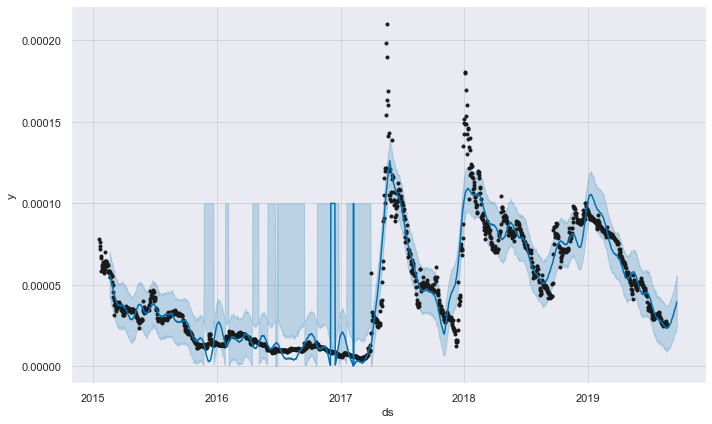

In [5]:
model = Prophet(changepoint_prior_scale=0.7,n_changepoints=25, daily_seasonality=True,changepoint_range=0.8).fit(df)
data_forecast = df['ds'] + pd.Timedelta(30, unit='days')
data_forecast = pd.DataFrame(data_forecast)
data_forecast.columns = ['ds']
forecast = model.predict(data_forecast)
forecast['yhat'] = np.where(forecast['yhat']<0,0.0001,forecast['yhat'])
forecast['yhat_lower'] = np.where(forecast['yhat_lower']<0,0.0001,forecast['yhat_lower'])
forecast['yhat_upper'] = np.where(forecast['yhat_upper']<0,0.0001,forecast['yhat_upper'])
model.plot(forecast);

In [6]:
res = pred[['RMSE','MAE','Accuracy']].groupby([pred['t']]).mean()
res.index = pd.Series(['July','June','May']) + '-2019'
res = pd.DataFrame(res)
res

,RMSE,MAE,Accuracy
July-2019,0.000010,0.000010,0.635642
June-2019,0.000004,0.000003,0.903325
May-2019,0.000011,0.000010,0.794683


In [7]:
final = forecast[['ds']].iloc[-30:]
final['weekday'] = final['ds'].dt.weekday
final['weekday'] = final['weekday'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
final[['Price','Low','High']] = forecast[['yhat','yhat_lower','yhat_upper']].iloc[-30:]
final.set_index('ds')

,weekday,Price,Low,High
ds,,,,
2019-08-22,Thursday,0.000024,0.000010,0.000038
2019-08-23,Friday,0.000024,0.000009,0.000038
2019-08-24,Saturday,0.000024,0.000011,0.000037
2019-08-25,Sunday,0.000024,0.000010,0.000038
2019-08-26,Monday,0.000024,0.000010,0.000037
2019-08-27,Tuesday,0.000024,0.000010,0.000037
2019-08-28,Wednesday,0.000024,0.000012,0.000038
2019-08-29,Thursday,0.000025,0.000011,0.000039
2019-08-30,Friday,0.000025,0.000012,0.000040


In [16]:
with open("simple.html", 'w') as _file:
    _file.write(res.to_html() + "\n\n" + final.to_html())

#### ETH

In [3]:
coin = 'ETH'
df = price.get_historical_data(coin, 'BTC', 'day', aggregate=1, limit=2000)
df = pd.DataFrame(df)
df = df[df['close']!=0]
df['Date'] = df['time'].apply(lambda x: x[:10])
df['Date'] = pd.to_datetime(df['Date'])
df = df[['close','Date']]
df.columns = ['y','ds']

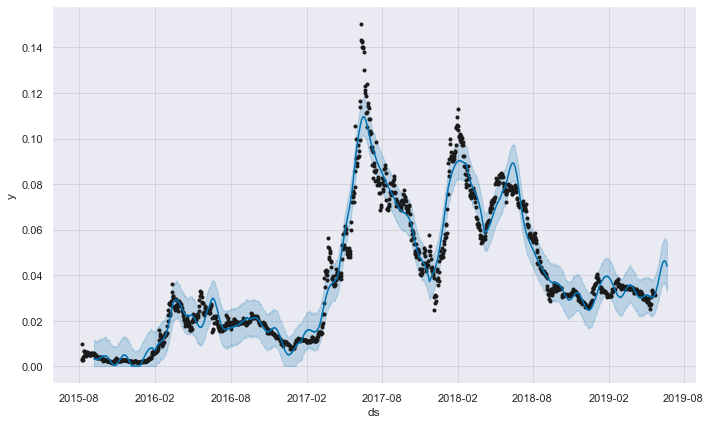

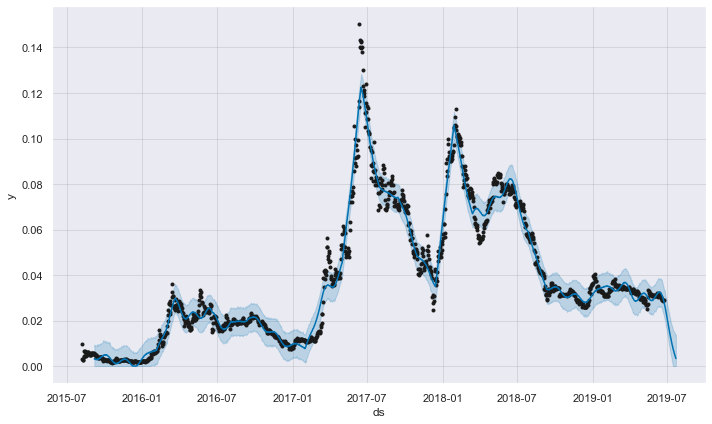

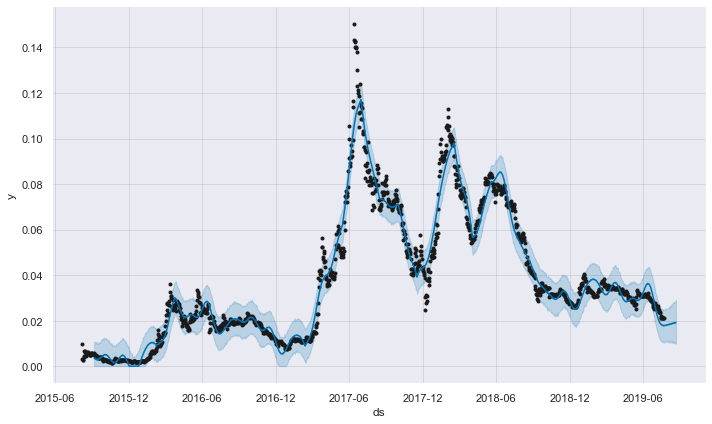

In [34]:
days = 30
t = [90,60,30]
pred = pd.DataFrame()
for te in t:
    data = df[['y','ds']][:-te]
    if te == 30:
        true = df['y'][-30:]
    else:
        true = df['y'][-te:-(te-days)]
    
    model = Prophet(changepoint_prior_scale=0.7,n_changepoints=25, daily_seasonality=True,changepoint_range=0.8).fit(data)

    data_forecast = data['ds'] + pd.Timedelta(30, unit='days')
    data_forecast = pd.DataFrame(data_forecast)
    data_forecast.columns = ['ds']
    forecast = model.predict(data_forecast)
    forecast['yhat'] = np.where(forecast['yhat']<0,0.0001,forecast['yhat'])
    forecast['yhat_lower'] = np.where(forecast['yhat_lower']<0,0.0001,forecast['yhat_lower'])
    forecast['yhat_upper'] = np.where(forecast['yhat_upper']<0,0.0001,forecast['yhat_upper'])
    model.plot(forecast);
    y = pd.DataFrame()
    y['True'] = true
    y['Forecasted'] = forecast['yhat'].iloc[-30:].values
    score = []
    for i in range(len(y)):
        if y['True'].iloc[i] > y['Forecasted'].iloc[i]:
            score.append(y['Forecasted'].iloc[i] / y['True'].iloc[i])
        else:
            score.append(y['True'].iloc[i] / y['Forecasted'].iloc[i])
    y['RMSE'] = np.sqrt(metrics.mean_squared_error(y['True'],y['Forecasted']))
    y['MAE'] = metrics.mean_absolute_error(y['True'],y['Forecasted'])
    y['Accuracy'] = score
    y['t'] = te
    pred = pd.concat([pred,y])

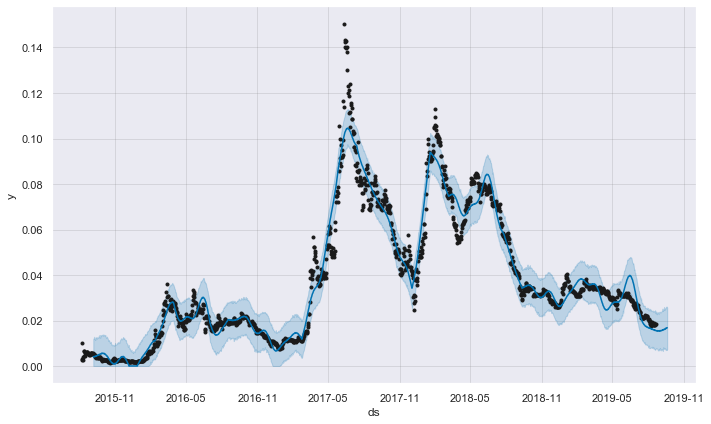

In [35]:
model = Prophet(changepoint_prior_scale=0.7,n_changepoints=25, daily_seasonality=True,changepoint_range=0.8).fit(df)
data_forecast = df['ds'] + pd.Timedelta(30, unit='days')
data_forecast = pd.DataFrame(data_forecast)
data_forecast.columns = ['ds']
forecast = model.predict(data_forecast)
forecast['yhat'] = np.where(forecast['yhat']<0,0.0001,forecast['yhat'])
forecast['yhat_lower'] = np.where(forecast['yhat_lower']<0,0.0001,forecast['yhat_lower'])
forecast['yhat_upper'] = np.where(forecast['yhat_upper']<0,0.0001,forecast['yhat_upper'])
model.plot(forecast);

In [36]:
res = pred[['RMSE','MAE','Accuracy']].groupby([pred['t']]).mean()
res.index = pd.Series(['Last month','2nd last month','3rd last month']) + '-2019'
res = pd.DataFrame(res)
res

,RMSE,MAE,Accuracy
Last month-2019,0.002383,0.001828,0.913703
2nd last month-2019,0.011128,0.009605,0.584536
3rd last month-2019,0.011687,0.010323,0.761184


In [37]:
final = forecast[['ds']].iloc[-30:]
final['weekday'] = final['ds'].dt.weekday
final['weekday'] = final['weekday'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
final[['Price','Low','High']] = forecast[['yhat','yhat_lower','yhat_upper']].iloc[-30:]
final.set_index('ds')

,weekday,Price,Low,High
ds,,,,
2019-08-22,Thursday,0.015571,0.007945,0.023962
2019-08-23,Friday,0.015586,0.007812,0.024008
2019-08-24,Saturday,0.015526,0.007837,0.022784
2019-08-25,Sunday,0.015660,0.007680,0.023609
2019-08-26,Monday,0.015417,0.007367,0.023625
2019-08-27,Tuesday,0.015545,0.006890,0.023230
2019-08-28,Wednesday,0.015578,0.007236,0.023735
2019-08-29,Thursday,0.015412,0.006918,0.022989
2019-08-30,Friday,0.015472,0.007569,0.023328


#### EOS

In [38]:
coin = 'EOS'
df = price.get_historical_data(coin, 'BTC', 'day', aggregate=1, limit=2000)
df = pd.DataFrame(df)
df = df[df['close']!=0]
df['Date'] = df['time'].apply(lambda x: x[:10])
df['Date'] = pd.to_datetime(df['Date'])
df = df[['close','Date']]
df.columns = ['y','ds']

I0821 16:59:15.785762  6008 forecaster.py:886] Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
I0821 16:59:20.089112  6008 forecaster.py:886] Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


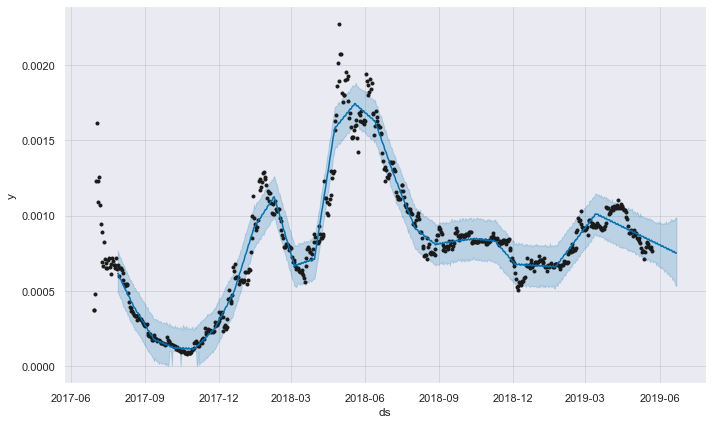

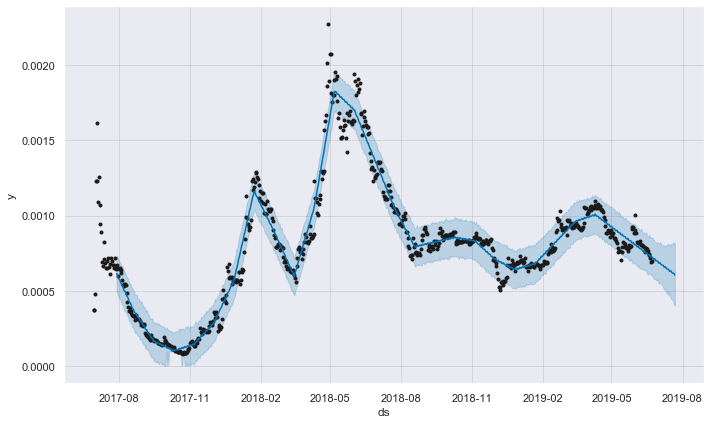

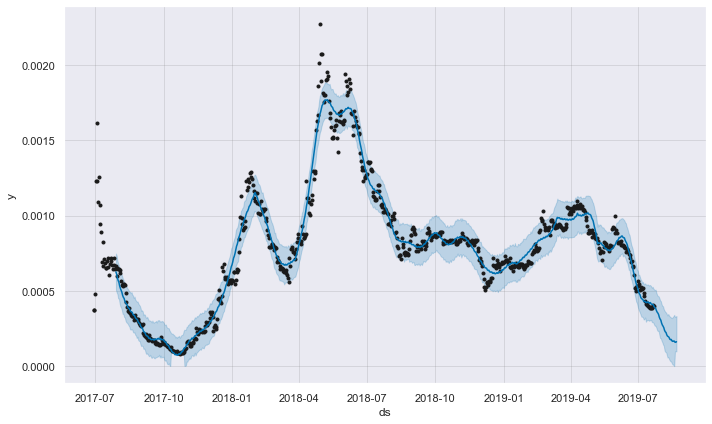

In [52]:
days = 30
t = [90,60,30]
pred = pd.DataFrame()
for te in t:
    data = df[['y','ds']][:-te]
    if te == 30:
        true = df['y'][-30:]
    else:
        true = df['y'][-te:-(te-days)]
    
    model = Prophet(changepoint_prior_scale=0.5,n_changepoints=25, daily_seasonality=True,changepoint_range=0.9).fit(data)

    data_forecast = data['ds'] + pd.Timedelta(30, unit='days')
    data_forecast = pd.DataFrame(data_forecast)
    data_forecast.columns = ['ds']
    forecast = model.predict(data_forecast)
    forecast['yhat'] = np.where(forecast['yhat']<0,0.0001,forecast['yhat'])
    forecast['yhat_lower'] = np.where(forecast['yhat_lower']<0,0.0001,forecast['yhat_lower'])
    forecast['yhat_upper'] = np.where(forecast['yhat_upper']<0,0.0001,forecast['yhat_upper'])
    model.plot(forecast);
    y = pd.DataFrame()
    y['True'] = true
    y['Forecasted'] = forecast['yhat'].iloc[-30:].values
    score = []
    for i in range(len(y)):
        if y['True'].iloc[i] > y['Forecasted'].iloc[i]:
            score.append(y['Forecasted'].iloc[i] / y['True'].iloc[i])
        else:
            score.append(y['True'].iloc[i] / y['Forecasted'].iloc[i])
    y['RMSE'] = np.sqrt(metrics.mean_squared_error(y['True'],y['Forecasted']))
    y['MAE'] = metrics.mean_absolute_error(y['True'],y['Forecasted'])
    y['Accuracy'] = score
    y['t'] = te
    pred = pd.concat([pred,y])

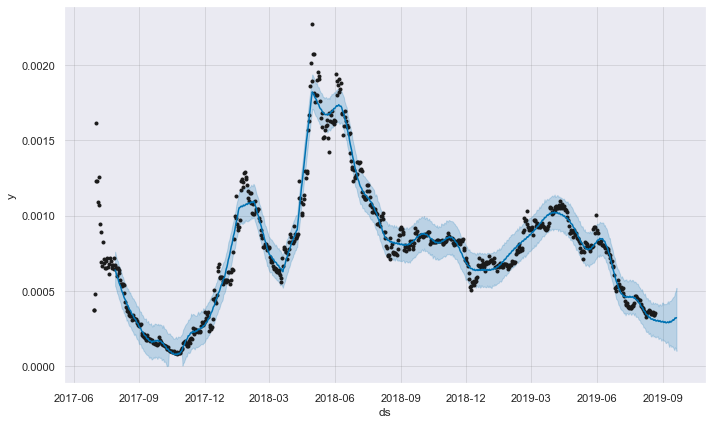

In [44]:
model = Prophet(changepoint_prior_scale=0.7,n_changepoints=25, daily_seasonality=True,changepoint_range=0.65).fit(df)
data_forecast = df['ds'] + pd.Timedelta(30, unit='days')
data_forecast = pd.DataFrame(data_forecast)
data_forecast.columns = ['ds']
forecast = model.predict(data_forecast)
forecast['yhat'] = np.where(forecast['yhat']<0,0.0001,forecast['yhat'])
forecast['yhat_lower'] = np.where(forecast['yhat_lower']<0,0.0001,forecast['yhat_lower'])
forecast['yhat_upper'] = np.where(forecast['yhat_upper']<0,0.0001,forecast['yhat_upper'])
model.plot(forecast);

In [53]:
res = pred[['RMSE','MAE','Accuracy']].groupby([pred['t']]).mean()
res.index = pd.Series(['Last month','2nd last month','3rd last month']) + '-2019'
res = pd.DataFrame(res)
res

,RMSE,MAE,Accuracy
Last month-2019,0.000146,0.000141,0.624892
2nd last month-2019,0.000191,0.000184,0.719367
3rd last month-2019,0.000060,0.000044,0.949595


In [42]:
final = forecast[['ds']].iloc[-30:]
final['weekday'] = final['ds'].dt.weekday
final['weekday'] = final['weekday'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
final[['Price','Low','High']] = forecast[['yhat','yhat_lower','yhat_upper']].iloc[-30:]
final.set_index('ds')

,weekday,Price,Low,High
ds,,,,
2019-08-22,Thursday,0.000353,0.000239,0.000475
2019-08-23,Friday,0.000355,0.000243,0.000475
2019-08-24,Saturday,0.000363,0.000242,0.000472
2019-08-25,Sunday,0.000368,0.000249,0.000486
2019-08-26,Monday,0.000365,0.000251,0.000480
2019-08-27,Tuesday,0.000369,0.000257,0.000490
2019-08-28,Wednesday,0.000378,0.000259,0.000488
2019-08-29,Thursday,0.000374,0.000260,0.000492
2019-08-30,Friday,0.000376,0.000260,0.000493


#### LTC

In [54]:
coin = 'LTC'
df = price.get_historical_data(coin, 'BTC', 'day', aggregate=1, limit=2000)
df = pd.DataFrame(df)
df = df[df['close']!=0]
df['Date'] = df['time'].apply(lambda x: x[:10])
df['Date'] = pd.to_datetime(df['Date'])
df = df[['close','Date']]
df.columns = ['y','ds']

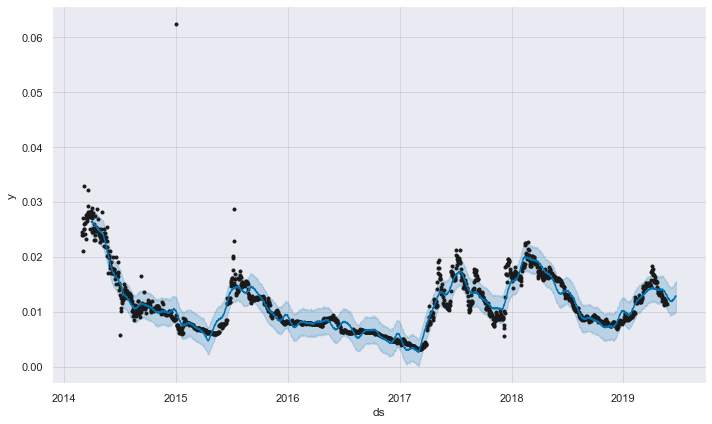

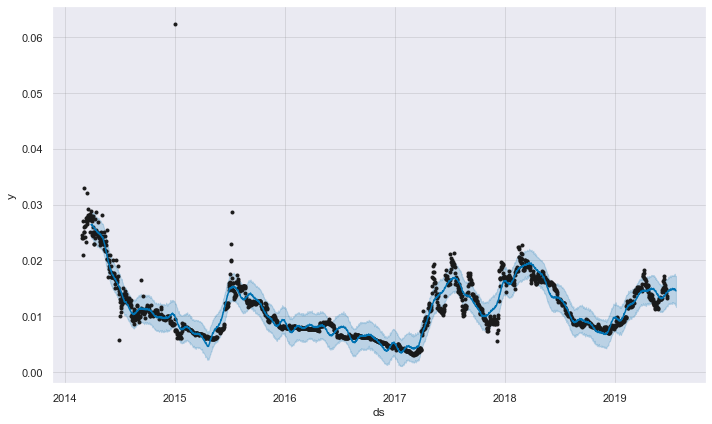

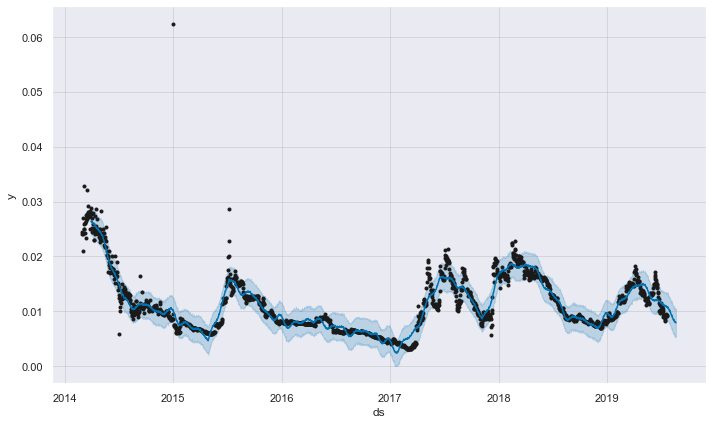

In [55]:
days = 30
t = [90,60,30]
pred = pd.DataFrame()
for te in t:
    data = df[['y','ds']][:-te]
    if te == 30:
        true = df['y'][-30:]
    else:
        true = df['y'][-te:-(te-days)]
    
    model = Prophet(changepoint_prior_scale=0.7,n_changepoints=25, daily_seasonality=True,changepoint_range=0.9).fit(data)

    data_forecast = data['ds'] + pd.Timedelta(30, unit='days')
    data_forecast = pd.DataFrame(data_forecast)
    data_forecast.columns = ['ds']
    forecast = model.predict(data_forecast)
    forecast['yhat'] = np.where(forecast['yhat']<0,0.0001,forecast['yhat'])
    forecast['yhat_lower'] = np.where(forecast['yhat_lower']<0,0.0001,forecast['yhat_lower'])
    forecast['yhat_upper'] = np.where(forecast['yhat_upper']<0,0.0001,forecast['yhat_upper'])
    model.plot(forecast);
    y = pd.DataFrame()
    y['True'] = true
    y['Forecasted'] = forecast['yhat'].iloc[-30:].values
    score = []
    for i in range(len(y)):
        if y['True'].iloc[i] > y['Forecasted'].iloc[i]:
            score.append(y['Forecasted'].iloc[i] / y['True'].iloc[i])
        else:
            score.append(y['True'].iloc[i] / y['Forecasted'].iloc[i])
    y['RMSE'] = np.sqrt(metrics.mean_squared_error(y['True'],y['Forecasted']))
    y['MAE'] = metrics.mean_absolute_error(y['True'],y['Forecasted'])
    y['Accuracy'] = score
    y['t'] = te
    pred = pd.concat([pred,y])

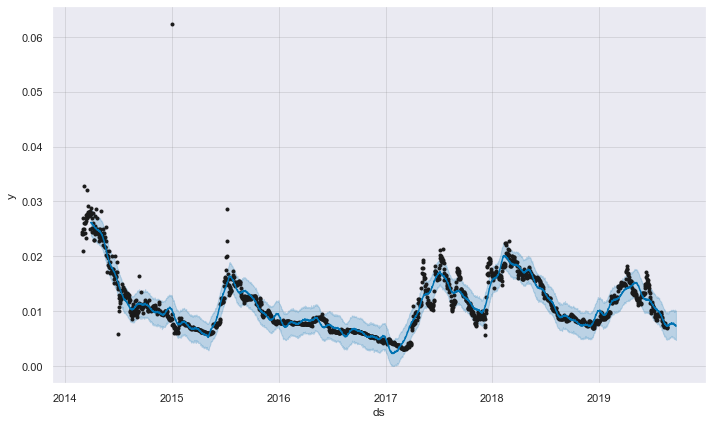

In [56]:
model = Prophet(changepoint_prior_scale=0.7,n_changepoints=25, daily_seasonality=True,changepoint_range=0.9).fit(df)
data_forecast = df['ds'] + pd.Timedelta(30, unit='days')
data_forecast = pd.DataFrame(data_forecast)
data_forecast.columns = ['ds']
forecast = model.predict(data_forecast)
forecast['yhat'] = np.where(forecast['yhat']<0,0.0001,forecast['yhat'])
forecast['yhat_lower'] = np.where(forecast['yhat_lower']<0,0.0001,forecast['yhat_lower'])
forecast['yhat_upper'] = np.where(forecast['yhat_upper']<0,0.0001,forecast['yhat_upper'])
model.plot(forecast);

In [57]:
res = pred[['RMSE','MAE','Accuracy']].groupby([pred['t']]).mean()
res.index = pd.Series(['Last month','2nd last month','3rd last month']) + '-2019'
res = pd.DataFrame(res)
res

,RMSE,MAE,Accuracy
Last month-2019,0.001103,0.001051,0.886363
2nd last month-2019,0.004799,0.004637,0.684920
3rd last month-2019,0.002402,0.001972,0.868181


In [58]:
final = forecast[['ds']].iloc[-30:]
final['weekday'] = final['ds'].dt.weekday
final['weekday'] = final['weekday'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
final[['Price','Low','High']] = forecast[['yhat','yhat_lower','yhat_upper']].iloc[-30:]
final.set_index('ds')

,weekday,Price,Low,High
ds,,,,
2019-08-22,Thursday,0.007505,0.005046,0.009950
2019-08-23,Friday,0.007314,0.004911,0.009588
2019-08-24,Saturday,0.007399,0.004916,0.009662
2019-08-25,Sunday,0.007391,0.004989,0.009618
2019-08-26,Monday,0.007364,0.004869,0.009630
2019-08-27,Tuesday,0.007509,0.005137,0.010048
2019-08-28,Wednesday,0.007506,0.005114,0.009891
2019-08-29,Thursday,0.007707,0.005257,0.009975
2019-08-30,Friday,0.007546,0.005100,0.010049


#### BNB

In [21]:
coin = 'GIVE'
df = price.get_historical_data(coin, 'BTC', 'day', aggregate=1, limit=2000)
df = pd.DataFrame(df)
df = df[df['close']!=0]
df['Date'] = df['time'].apply(lambda x: x[:10])
df['Date'] = pd.to_datetime(df['Date'])
df = df[['close','Date']]
df.columns = ['y','ds']

In [27]:
df['y'] *= 1000

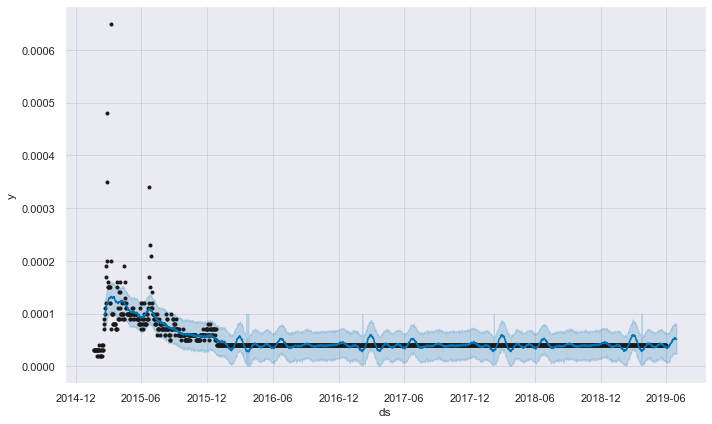

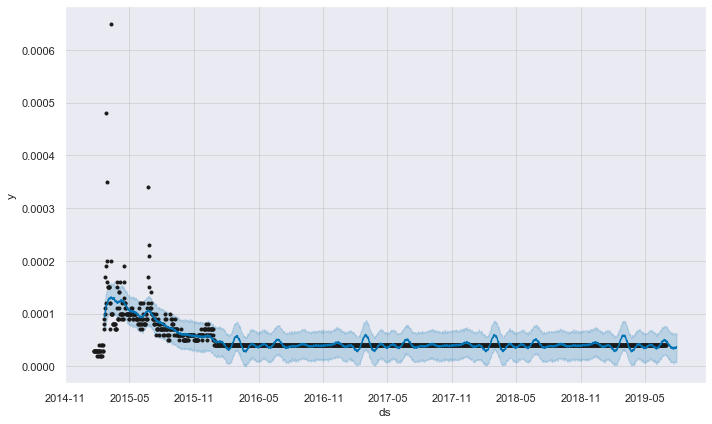

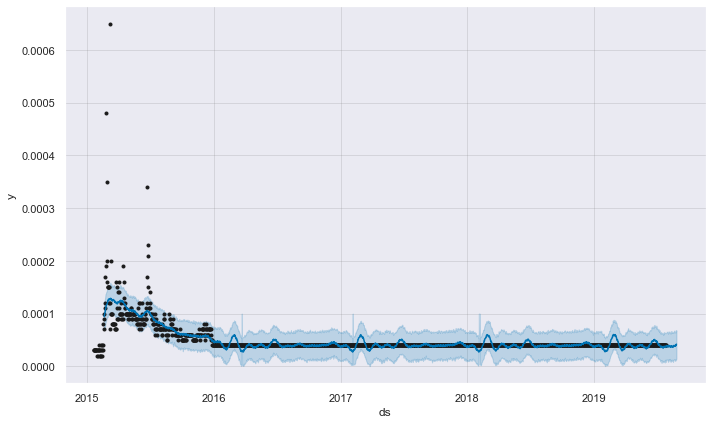

In [28]:
days = 30
t = [90,60,30]
pred = pd.DataFrame()
for te in t:
    data = df[['y','ds']][:-te]
    if te == 30:
        true = df['y'][-30:]
    else:
        true = df['y'][-te:-(te-days)]
    
    model = Prophet(changepoint_prior_scale=0.7,n_changepoints=25, daily_seasonality=True,changepoint_range=0.9).fit(data)

    data_forecast = data['ds'] + pd.Timedelta(30, unit='days')
    data_forecast = pd.DataFrame(data_forecast)
    data_forecast.columns = ['ds']
    forecast = model.predict(data_forecast)
    forecast['yhat'] = np.where(forecast['yhat']<0,0.0001,forecast['yhat'])
    forecast['yhat_lower'] = np.where(forecast['yhat_lower']<0,0.0001,forecast['yhat_lower'])
    forecast['yhat_upper'] = np.where(forecast['yhat_upper']<0,0.0001,forecast['yhat_upper'])
    model.plot(forecast);
    y = pd.DataFrame()
    y['True'] = true
    y['Forecasted'] = forecast['yhat'].iloc[-30:].values
    score = []
    for i in range(len(y)):
        if y['True'].iloc[i] > y['Forecasted'].iloc[i]:
            score.append(y['Forecasted'].iloc[i] / y['True'].iloc[i])
        else:
            score.append(y['True'].iloc[i] / y['Forecasted'].iloc[i])
    y['RMSE'] = np.sqrt(metrics.mean_squared_error(y['True'],y['Forecasted']))
    y['MAE'] = metrics.mean_absolute_error(y['True'],y['Forecasted'])
    y['Accuracy'] = score
    y['t'] = te
    pred = pd.concat([pred,y])

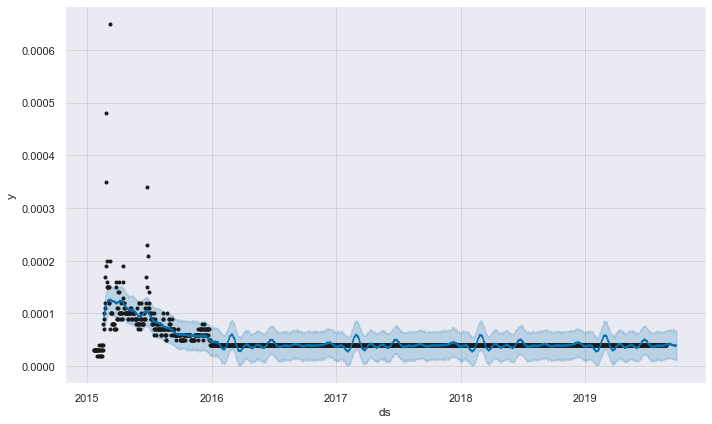

In [29]:
model = Prophet(changepoint_prior_scale=0.7,n_changepoints=25, daily_seasonality=True,changepoint_range=0.9).fit(df)
data_forecast = df['ds'] + pd.Timedelta(30, unit='days')
data_forecast = pd.DataFrame(data_forecast)
data_forecast.columns = ['ds']
forecast = model.predict(data_forecast)
forecast['yhat'] = np.where(forecast['yhat']<0,0.0001,forecast['yhat'])
forecast['yhat_lower'] = np.where(forecast['yhat_lower']<0,0.0001,forecast['yhat_lower'])
forecast['yhat_upper'] = np.where(forecast['yhat_upper']<0,0.0001,forecast['yhat_upper'])
model.plot(forecast);

In [30]:
res = pred[['RMSE','MAE','Accuracy']].groupby([pred['t']]).mean()
res.index = pd.Series(['Last month','2nd last month','3rd last month']) + '-2019'
res = pd.DataFrame(res)
res

,RMSE,MAE,Accuracy
Last month-2019,0.000002,0.000002,0.949289
2nd last month-2019,0.000005,0.000004,0.896191
3rd last month-2019,0.000008,0.000007,0.853695


In [31]:
final = forecast[['ds']].iloc[-30:]
final['weekday'] = final['ds'].dt.weekday
final['weekday'] = final['weekday'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
final[['Price','Low','High']] = forecast[['yhat','yhat_lower','yhat_upper']].iloc[-30:]
final.set_index('ds')

,weekday,Price,Low,High
ds,,,,
2019-08-29,Thursday,0.000042,0.000017,0.000068
2019-08-30,Friday,0.000041,0.000014,0.000068
2019-08-31,Saturday,0.000041,0.000014,0.000067
2019-09-01,Sunday,0.000040,0.000015,0.000068
2019-09-02,Monday,0.000043,0.000019,0.000070
2019-09-03,Tuesday,0.000042,0.000014,0.000067
2019-09-04,Wednesday,0.000043,0.000017,0.000070
2019-09-05,Thursday,0.000043,0.000017,0.000069
2019-09-06,Friday,0.000041,0.000016,0.000069


#### Other

In [137]:
coin = 'SRN'
df = price.get_historical_data(coin, 'BTC', 'day', aggregate=1, limit=2000)
df = pd.DataFrame(df)
df = df[df['close']!=0]
df['Date'] = df['time'].apply(lambda x: x[:10])
df['Date'] = pd.to_datetime(df['Date'])
df = df[['close','Date']]
df.columns = ['y','ds']

I0821 17:30:45.066330  6008 forecaster.py:886] Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
I0821 17:30:49.642588  6008 forecaster.py:886] Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
I0821 17:30:54.471775  6008 forecaster.py:886] Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


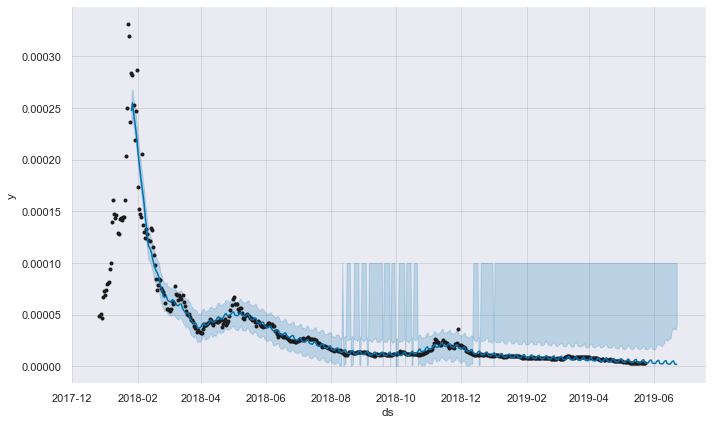

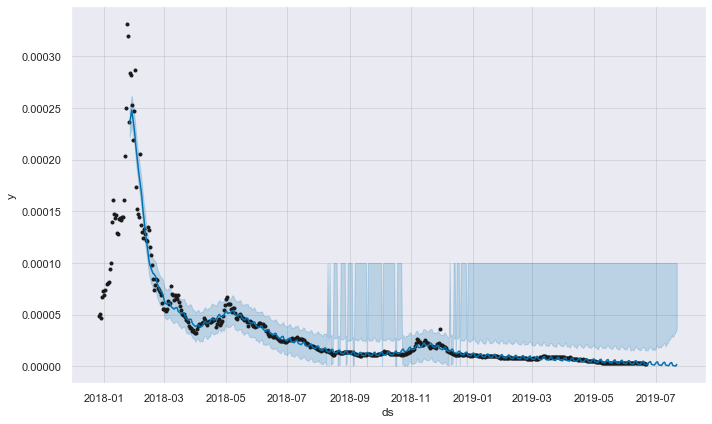

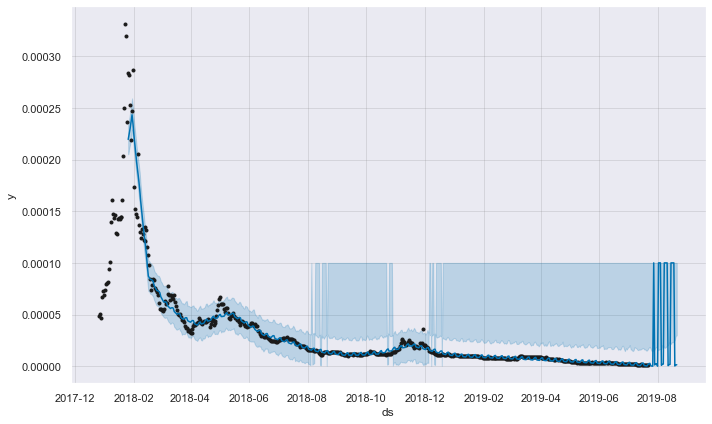

In [142]:
days = 30
t = [90,60,30]
pred = pd.DataFrame()
for te in t:
    data = df[['y','ds']][:-te]
    if te == 30:
        true = df['y'][-30:]
    else:
        true = df['y'][-te:-(te-days)]
    
    model = Prophet(changepoint_prior_scale=0.7,n_changepoints=25, daily_seasonality=True,changepoint_range=0.75).fit(data)

    data_forecast = data['ds'] + pd.Timedelta(30, unit='days')
    data_forecast = pd.DataFrame(data_forecast)
    data_forecast.columns = ['ds']
    forecast = model.predict(data_forecast)
    forecast['yhat'] = np.where(forecast['yhat']<0,0.0001,forecast['yhat'])
    forecast['yhat_lower'] = np.where(forecast['yhat_lower']<0,0.0001,forecast['yhat_lower'])
    forecast['yhat_upper'] = np.where(forecast['yhat_upper']<0,0.0001,forecast['yhat_upper'])
    model.plot(forecast);
    y = pd.DataFrame()
    y['True'] = true
    y['Forecasted'] = forecast['yhat'].iloc[-30:].values
    score = []
    for i in range(len(y)):
        if y['True'].iloc[i] > y['Forecasted'].iloc[i]:
            score.append(y['Forecasted'].iloc[i] / y['True'].iloc[i])
        else:
            score.append(y['True'].iloc[i] / y['Forecasted'].iloc[i])
    y['RMSE'] = np.sqrt(metrics.mean_squared_error(y['True'],y['Forecasted']))
    y['MAE'] = metrics.mean_absolute_error(y['True'],y['Forecasted'])
    y['Accuracy'] = score
    y['t'] = te
    pred = pd.concat([pred,y])

In [143]:
res = pred[['RMSE','MAE','Accuracy']].groupby([pred['t']]).mean()
res.index = pd.Series(['Last month','2nd last month','3rd last month']) + '-2019'
res = pd.DataFrame(res)
res

,RMSE,MAE,Accuracy
Last month-2019,0.000063,0.000040,0.302716
2nd last month-2019,0.000001,0.000001,0.581869
3rd last month-2019,0.000001,0.000001,0.746265


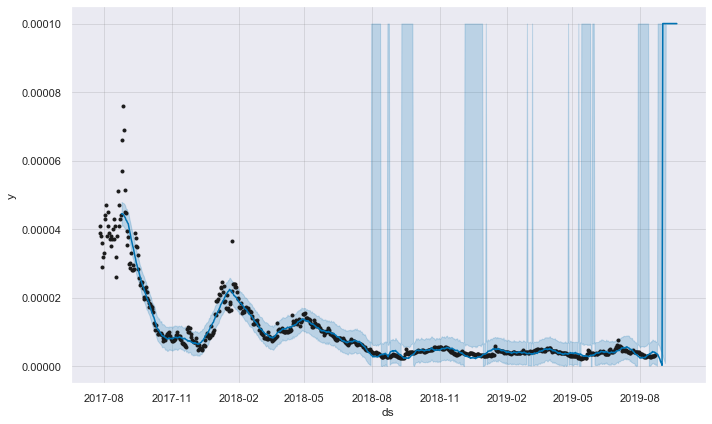

In [106]:
model = Prophet(changepoint_prior_scale=0.7,n_changepoints=25, daily_seasonality=True,changepoint_range=0.65).fit(df)
data_forecast = df['ds'] + pd.Timedelta(30, unit='days')
data_forecast = pd.DataFrame(data_forecast)
data_forecast.columns = ['ds']
forecast = model.predict(data_forecast)
forecast['yhat'] = np.where(forecast['yhat']<0,0.0001,forecast['yhat'])
forecast['yhat_lower'] = np.where(forecast['yhat_lower']<0,0.0001,forecast['yhat_lower'])
forecast['yhat_upper'] = np.where(forecast['yhat_upper']<0,0.0001,forecast['yhat_upper'])
model.plot(forecast);

In [90]:
final = forecast[['ds']].iloc[-30:]
final['weekday'] = final['ds'].dt.weekday
final['weekday'] = final['weekday'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
final[['Price','Low','High']] = forecast[['yhat','yhat_lower','yhat_upper']].iloc[-30:]
final.set_index('ds')

,weekday,Price,Low,High
ds,,,,
2019-08-22,Thursday,0.000424,0.000346,0.000499
2019-08-23,Friday,0.000426,0.000354,0.000497
2019-08-24,Saturday,0.000424,0.000344,0.000502
2019-08-25,Sunday,0.000424,0.000353,0.000500
2019-08-26,Monday,0.000423,0.000355,0.000496
2019-08-27,Tuesday,0.000424,0.000341,0.000502
2019-08-28,Wednesday,0.000424,0.000353,0.000495
2019-08-29,Thursday,0.000425,0.000350,0.000495
2019-08-30,Friday,0.000427,0.000355,0.000504


### automate

In [17]:
coin = 'SRN'
df = price.get_historical_data(coin, 'BTC', 'day', aggregate=1, limit=2000)
df = pd.DataFrame(df)
df = df[df['close']!=0]
df['Date'] = df['time'].apply(lambda x: x[:10])
df['Date'] = pd.to_datetime(df['Date'])
df = df[['close','Date']]
df.columns = ['y','ds']

In [36]:
t1 = 0
t2 = 0
for change in [0.9,0.8,0.75,0.65,0.35]:
    days = 30
    t = [90,60,30]
    pred = pd.DataFrame()
    for te in t:
        data = df[['y','ds']][:-te]
        if te == 30:
            true = df['y'][-30:]
        else:
            true = df['y'][-te:-(te-days)]

        model = Prophet(changepoint_prior_scale=0.7,n_changepoints=25, daily_seasonality=False,yearly_seasonality=False,
                        changepoint_range=change).fit(data)

        data_forecast = data['ds'] + pd.Timedelta(30, unit='days')
        data_forecast = pd.DataFrame(data_forecast)
        data_forecast.columns = ['ds']
        forecast = model.predict(data_forecast)
        forecast['yhat'] = np.where(forecast['yhat']<0,0.000001,forecast['yhat'])
        forecast['yhat_lower'] = np.where(forecast['yhat_lower']<0,0.000001,forecast['yhat_lower'])
        forecast['yhat_upper'] = np.where(forecast['yhat_upper']<0,0.000001,forecast['yhat_upper'])
        #model.plot(forecast);
        y = pd.DataFrame()
        y['True'] = true
        y['Forecasted'] = forecast['yhat'].iloc[-30:].values
        score = []
        for i in range(len(y)):
            if y['True'].iloc[i] > y['Forecasted'].iloc[i]:
                score.append(y['Forecasted'].iloc[i] / y['True'].iloc[i])
            else:
                score.append(y['True'].iloc[i] / y['Forecasted'].iloc[i])
        y['RMSE'] = np.sqrt(metrics.mean_squared_error(y['True'],y['Forecasted']))
        y['MAE'] = metrics.mean_absolute_error(y['True'],y['Forecasted'])
        y['Accuracy'] = score
        y['t'] = te
        pred = pd.concat([pred,y])

    res = pred[['RMSE','MAE','Accuracy']].groupby([pred['t']]).mean()
    res.index = pd.Series(['Last month','2nd last month','3rd last month']) + '-2019'
    res = pd.DataFrame(res)
    print(res)
    if t1 == 0 and t2 == 0:
        t1 = change
        t2 = res['Accuracy'].mean()
        
    else:
        if t2 < res['Accuracy'].mean():
            t2 = res['Accuracy'].mean()
            t1 = change

                        RMSE      MAE  Accuracy
Last month-2019     0.000001 0.000000  0.749469
2nd last month-2019 0.000001 0.000001  0.556792
3rd last month-2019 0.000002 0.000001  0.518201
                        RMSE      MAE  Accuracy
Last month-2019     0.000001 0.000000  0.770232
2nd last month-2019 0.000001 0.000001  0.524091
3rd last month-2019 0.000002 0.000001  0.643450
                        RMSE      MAE  Accuracy
Last month-2019     0.000001 0.000000  0.726990
2nd last month-2019 0.000001 0.000001  0.501039
3rd last month-2019 0.000002 0.000001  0.633384
                        RMSE      MAE  Accuracy
Last month-2019     0.000001 0.000000  0.722146
2nd last month-2019 0.000001 0.000001  0.541528
3rd last month-2019 0.000002 0.000001  0.532242
                        RMSE      MAE  Accuracy
Last month-2019     0.000001 0.000001  0.673917
2nd last month-2019 0.000001 0.000001  0.505619
3rd last month-2019 0.000002 0.000001  0.608384


In [37]:
res['Accuracy'].mean()

0.5959736700114578

In [38]:
t1,t2

(0.8, 0.6459243596283925)

In [42]:
with open("param.csv", "a") as myfile:
    myfile.write('\n'+coin+',0.7,25,True,'+str(t1))

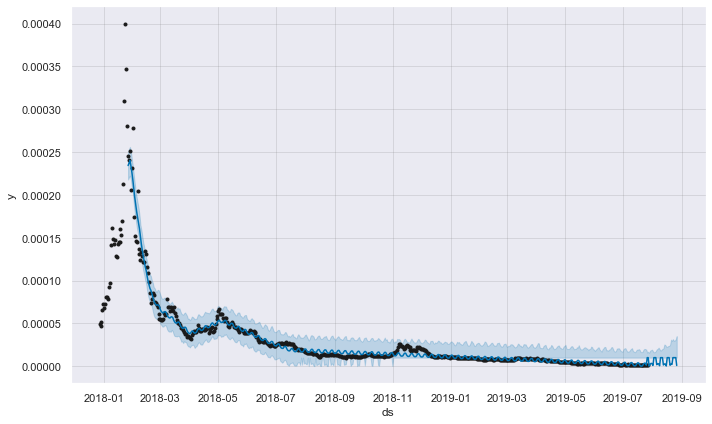

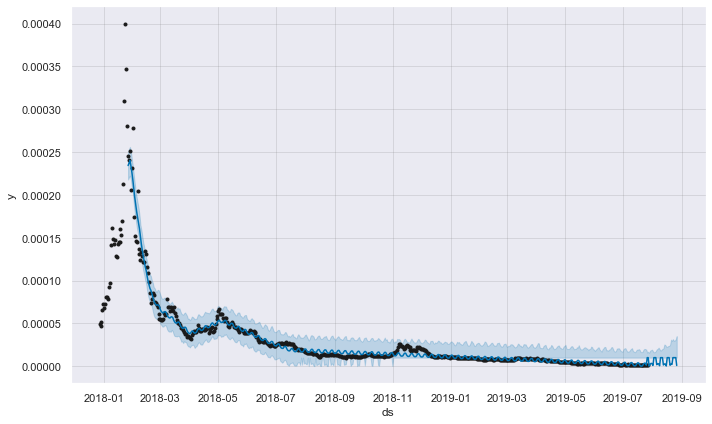

In [30]:
model.plot(forecast)